# Entanglement Swapping
This script swaps entanglement between two spatially seperated qbits that do not come into direct contact with each other. Two qbit tomography and readout calibration are used to find the resulting state, before calculating the fidelity of the output to the expected output.

In [1]:
import numpy as np
import pandas as pd
import random
# %config InlineBackend.figure_format = 'svg' # Makes the images look nice

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_state_paulivec
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, concurrence, DensityMatrix

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account() # credentials stored on disk
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington

# necessary imports for noise modelling
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

## Defining the expected state

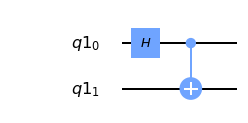

In [3]:
# creating a random initial state for 0th qbit
R = []
for i in range(3):
    R.append(10*random.random())

qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


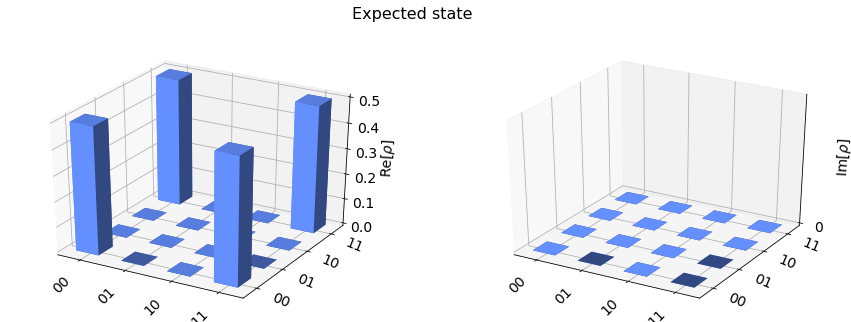

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

## Defining the circuit

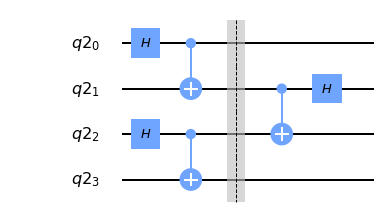

In [5]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr)
#qc.rx((np.pi*R[0])/10,0)
#qc.ry((np.pi*R[1])/10,0)
#qc.rz((np.pi*R[2])/10,0)
qc.h(0)
qc.h(2)
qc.cx(0,1)
qc.cx(2,3)
qc.barrier()
qc.cx(1,2)
qc.h(1)
qc.draw(output='mpl')

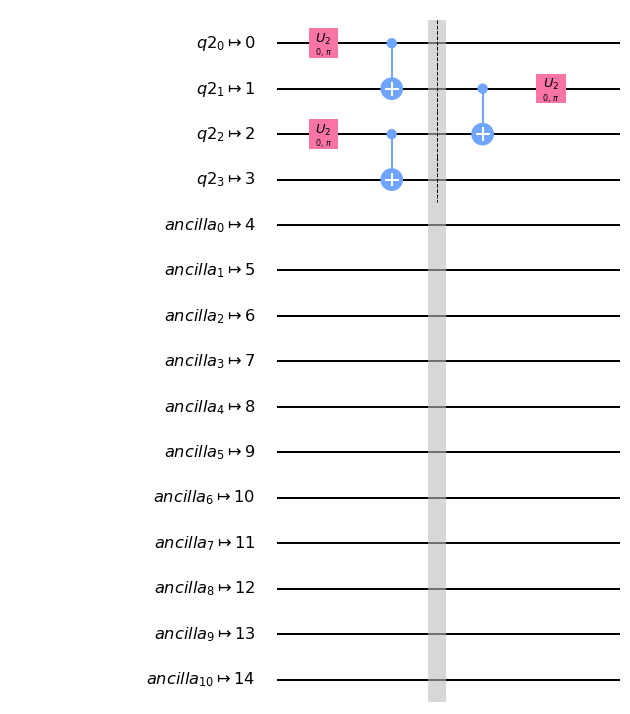

In [6]:
# what does this circuit look like on the device?
transpile_qc = qiskit.compiler.transpile(qc,device)
transpile_qc.draw(output='mpl')

## Readout correction
Calibration is performed on the first and last qbit of the circuit only.

Job Status: job has successfully run


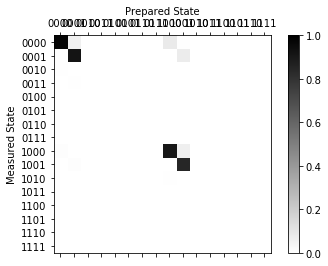

In [7]:
#readout calibration measurements
clz, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
# doing calibration only for qbit 0 and 3, for 00, 10, 01, 11
cal_circuit = [clz[0], clz[8], clz[1], clz[9]]
cal_job = qiskit.execute(cal_circuit, backend = device, shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [8]:
bits = ['0000', '1000', '0001', '1001', 
        '0010', '1010', '0011', '1011',
        '0100', '1100', '0101', '1101', 
        '0110', '1110', '0111', '1111']

counts = [0,0,0,0]
for i in range(4):
    counts[i] = calres.get_counts(cal_circuit[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m_IZ = [0,0,0,0]
m_ZI = [0,0,0,0]
m_ZZ = [0,0,0,0]
for i in range(4):
    for num, bit in enumerate(bits):
        if num % 4 == 0 or num % 4 == 1:
            m_IZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 2 or num % 4 == 3:
            m_IZ[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 2:
            m_ZI[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 3:
            m_ZI[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 3:
            m_ZZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 2:
            m_ZZ[i] -= float(counts[i][bit]) / 8192

M = [[1,  1,  1,  1], 
     [1,  1, -1, -1], 
     [1, -1,  1, -1], 
     [1, -1, -1,  1]]
Minv = np.linalg.inv(M)

beta_IZ = np.dot(Minv, m_IZ)
beta_ZI = np.dot(Minv, m_ZI)
beta_ZZ = np.dot(Minv, m_ZZ)

b_vec = [beta_IZ[0], beta_ZI[0], beta_ZZ[0]]
B = [beta_IZ[1:], beta_ZI[1:], beta_ZZ[1:]]
Binv = np.linalg.inv(B)

print(B)
print(b_vec)

[array([ 0.92926025, -0.00640869,  0.00274658]), array([ 0.00201416,  0.90667725, -0.00128174]), array([0.07043457, 0.0567627 , 0.84204102])]
[0.06365966796875, 0.07257080078125, 0.0009765625]


## State Tomography
In order to reconstruct the output state of the circuit, it is necessary to perform 2 qbit tomography to build an arbitrary state from the outcomes of a series of measurements that together give the full state. For 2 qbits, that is 9 (3^n) circuits.

In [9]:
# defining tomography circuits
qcz = state_tomography_circuits(qc,qr)
# qiskit creates all 81 tomography circuits for 4 qbits, we want just a subset of that:
# the nine circuits are in the order [XZZX, XZZY, XZZZ, YZZX, YZZY, YZZZ, ZZZX, ZZZY, ZZZZ]
qst_circuit = [qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]

# drawing one of the tomography circuits to check
# qst_circuit[0].draw(output='mpl')

In [10]:
backends = ['simulator', 'simulator_noise', device]

paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),
          ('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),
          ('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]

basis = ['XX','YX','ZX',
         'XY','YY','ZY',
         'XZ','YZ','ZZ']

for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit] = 0
    
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, IX @ psi, IZ @ psi, IZ @ IX @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}

    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

The full state for the simulator is                                            XX  \
0  {'00': 1034, '01': 0, '10': 0, '11': 1036}   
1   {'00': 0, '01': 988, '10': 1075, '11': 0}   
2   {'00': 1062, '01': 0, '10': 0, '11': 946}   
3  {'00': 0, '01': 1023, '10': 1028, '11': 0}   

                                             YX  \
0  {'00': 546, '01': 494, '10': 497, '11': 506}   
1  {'00': 492, '01': 502, '10': 488, '11': 568}   
2  {'00': 511, '01': 527, '10': 523, '11': 502}   
3  {'00': 523, '01': 470, '10': 516, '11': 527}   

                                             ZX  \
0  {'00': 558, '01': 533, '10': 514, '11': 458}   
1  {'00': 550, '01': 513, '10': 505, '11': 523}   
2  {'00': 472, '01': 504, '10': 521, '11': 497}   
3  {'00': 515, '01': 530, '10': 498, '11': 501}   

                                             XY  \
0  {'00': 497, '01': 471, '10': 528, '11': 513}   
1  {'00': 525, '01': 506, '10': 514, '11': 545}   
2  {'00': 498, '01': 485, '10': 524, '11': 542}   
3 

In [11]:
# defining the matrices to construct the density matrices
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)
XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [12]:
# there are 4 density matrices to calculate for each of sim, sim_noise and dev

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros((4, 9))
# there are three IX type terms and each can be calculated three ways (from XX, YX, ZX for IX)
r_IP = np.zeros((4, 9))
r_PI = np.zeros((4, 9))
r_IPavg = np.zeros((4, 3))
r_PIavg = np.zeros((4, 3))

m = np.zeros((4,9,3))
r_corr = np.zeros((4,9,3))
r_IPavg_corr = np.zeros((4, 3))
r_PIavg_corr = np.zeros((4, 3))

state_tot=[state_sim,state_sim_noise,state_dev]
rho=[0,0,0,0]

for stat, states in enumerate(state_tot):
    rhof = [0,0,0,0]
    for i in range(4):
        for j in range(9):
            r_exp[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*1)/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
            r_IP[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(-1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
            r_PI[i,j] = (states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(-1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*(-1))/(states[basis[j]][i]['00']*1 + states[basis[j]][i]['10']*(1) + states[basis[j]][i]['01']*(1) + states[basis[j]][i]['11']*1)
            
    for i in range(4):
        for j in range(3):
                r_IPavg[i,j]  = (r_IP[i,j] + r_IP[i,j+3] + r_IP[i,j+6])/3
                r_PIavg[i,j] = (r_PI[i,3*j] + r_PI[i,3*j+1] + r_PI[i,3*j+2])/3
    for i in range(4):
        rhof[i] = (1/4)*(Iden + r_exp[i,0]*XXPaul + r_exp[i,1]*XYPaul + r_exp[i,2]*XZPaul
                              + r_exp[i,3]*YXPaul + r_exp[i,4]*YYPaul + r_exp[i,5]*YZPaul
                              + r_exp[i,6]*ZXPaul + r_exp[i,7]*ZYPaul + r_exp[i,8]*ZZPaul
                              + r_IPavg[i,0]*IXPaul + r_PIavg[i,0]*XIPaul
                              + r_IPavg[i,1]*IYPaul + r_PIavg[i,1]*YIPaul
                              + r_IPavg[i,2]*IZPaul + r_PIavg[i,2]*ZIPaul)
        rho[stat] = rhof

# performing corrections for readout error and storing result in another density matrix
for i in range(4):
    for num, bas in enumerate(basis):
        m[i,num,:] = [r_IP[i,num], r_PI[i, num], r_exp[i,num]]
        r_corr[i,num] = np.dot(Binv, np.subtract(m[i,num,:],b_vec))

rho_corr = [0,0,0,0]
for i in range(4):
    for j in range(3):
            r_IPavg_corr[i,j] = (r_corr[i,j][0] + r_corr[i,j+3][0] + r_corr[i,j+6][0])/3
            r_PIavg_corr[i,j] = (r_corr[i,3*j][1] + r_corr[i,3*j+1][1] + r_corr[i,3*j+2][1])/3

    rho_corr[i] = (1/4)*(Iden + r_corr[i,0][2]*XXPaul + r_corr[i,1][2]*XYPaul + r_corr[i,2][2]*XZPaul
                              + r_corr[i,3][2]*YXPaul + r_corr[i,4][2]*YYPaul + r_corr[i,5][2]*YZPaul
                              + r_corr[i,6][2]*ZXPaul + r_corr[i,7][2]*ZYPaul + r_corr[i,8][2]*ZZPaul
                              + r_IPavg_corr[i,0]*IXPaul + r_PIavg_corr[i,0]*XIPaul
                              + r_IPavg_corr[i,1]*IYPaul + r_PIavg_corr[i,1]*YIPaul
                              + r_IPavg_corr[i,2]*IZPaul + r_PIavg_corr[i,2]*ZIPaul)

rho[3] = rho_corr

# applying the corrections for the 3 outcomes for which an X, Z or both gates are required
for ind in range(4):
    rho[ind][1] = ZIPaul @ rho[ind][1] @ ZIPaul
    rho[ind][2] = XIPaul @ rho[ind][2] @ XIPaul
    rho[ind][3] = XIPaul @ IZPaul @ rho[ind][3] @ IZPaul @ XIPaul
    
# # finding the average density matrix from the four possible outcomes
# rho_avg = [0,0,0,0]
# for i in range(4):
#     rho_avg[i] = np.mean(np.array([rho[i][0], rho[i][1], rho[i][2], rho[i][3]]), axis=0)

## Calculating Fidelities

In [13]:
Fidelity = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[i][j], validate=False)

F = np.mean(Fidelity,axis=1)
print(F)
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Calibrated Device Fidelity', F[3])

[1.         0.73181131 0.74896664 0.84434763]
Simulator Fidelity: 1.0
Noisy Simulator Fidelity: 0.7318113097631436
Device Fidelity: 0.7489666430666255
Calibrated Device Fidelity 0.84434762678206


In [14]:
# calculating statistical error to check whether simulator is within it from 1
err_bar = 1/np.sqrt(8192)
print('The statistical error for 8192 shots is:', err_bar)
print('The possible values of the simulator Fidelity \
range from {} to {}'.format(F[0]+err_bar,F[0]-err_bar))
# The simulator fidelity is within statistical error of 1, as expected.

The statistical error for 8192 shots is: 0.011048543456039804
The possible values of the simulator Fidelity range from 1.01104854345604 to 0.9889514565439602


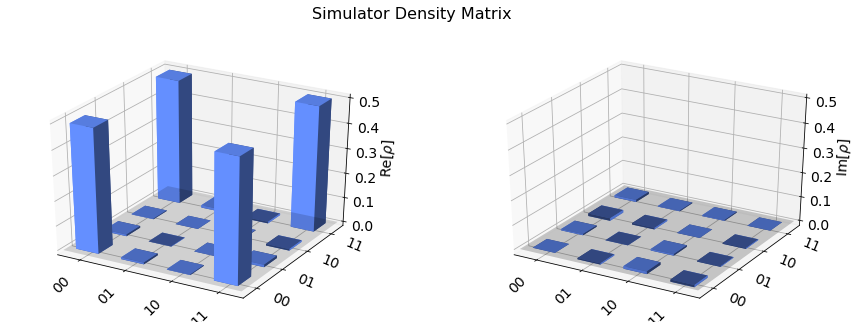

In [15]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

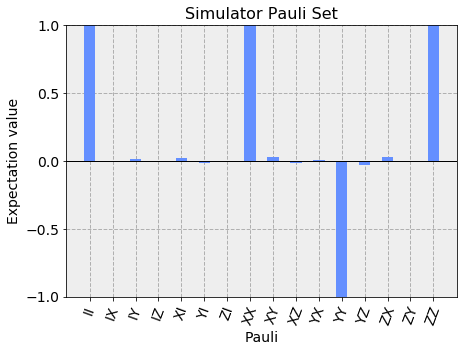

In [16]:
plot_state_paulivec(rho[0][0], title='Simulator Pauli Set')

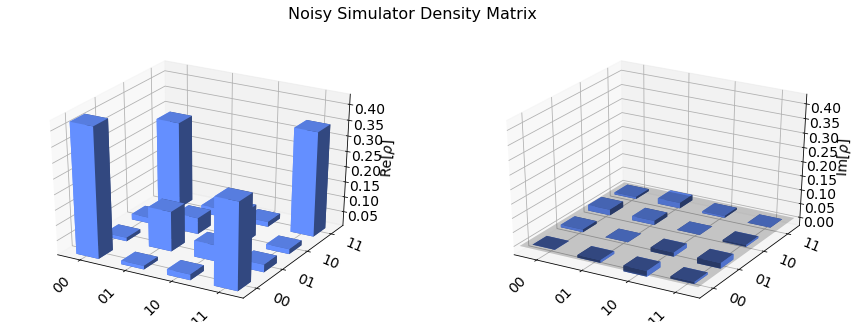

In [17]:
plot_state_city(rho[1][0], title='Noisy Simulator Density Matrix')

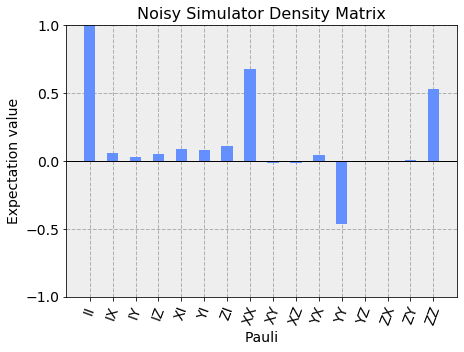

In [18]:
plot_state_paulivec(rho[1][0], title='Noisy Simulator Density Matrix')

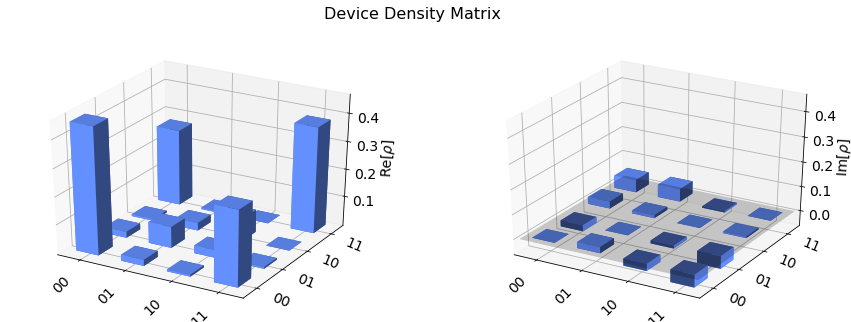

In [19]:
plot_state_city(rho[2][0], title='Device Density Matrix')

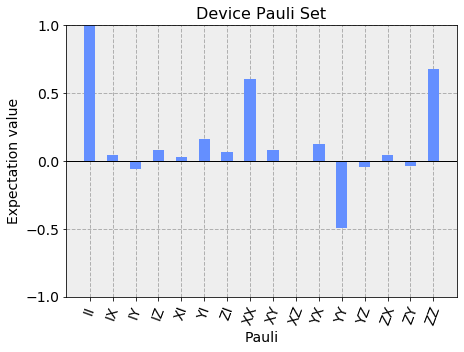

In [20]:
plot_state_paulivec(rho[2][0], title='Device Pauli Set')

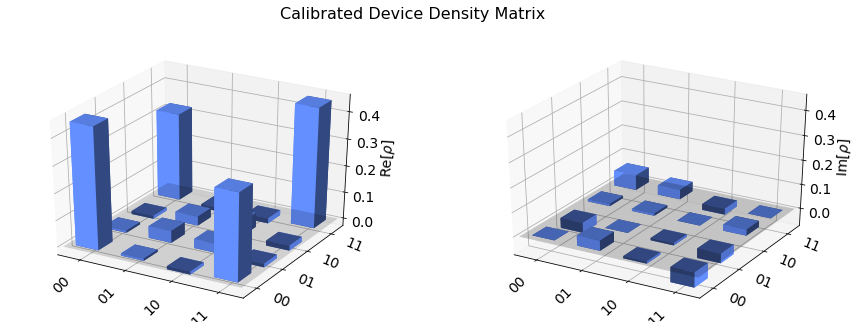

In [21]:
plot_state_city(rho[3][0], title='Calibrated Device Density Matrix')

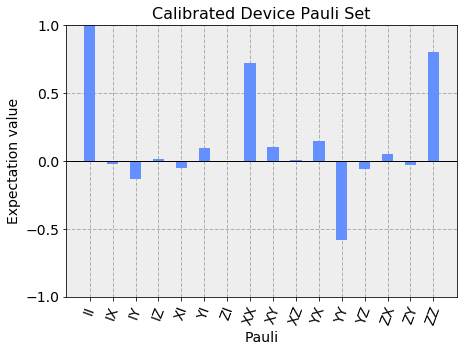

In [22]:
plot_state_paulivec(rho[3][0], title='Calibrated Device Pauli Set')

In [23]:
# checking validity of the density matrices
print('Is the simulator density matrix valid?', DensityMatrix(rho[1][0]).is_valid())
print('Is the device density matrix valid?', DensityMatrix(rho[2][0]).is_valid())

Is the simulator density matrix valid? True
Is the device density matrix valid? True


In [24]:
import qiskit.tools.jupyter
%qiskit_version_table